In [107]:
from dolfin import *
import numpy as np

In [108]:
mesh = Mesh("./Haiti.xml")
subdomains = MeshFunction("size_t", mesh, "Haiti_physical_region.xml")
sub_bd = MeshFunction("size_t", mesh, "Haiti_facet_region.xml")

In [109]:
bdfile = File("boundaries.pvd")
bdfile << sub_bd

dmfile = File("subdomains.pvd")
dmfile << subdomains


In [110]:
#Define function space
V = FunctionSpace(mesh,'DG',0)


# Define test and trial functions
B = TrialFunction(V)
S = TrialFunction(V)
I = TrialFunction(V)
R = TrialFunction(V)
v = TestFunction(V)

#Create functions
B0 = Function(V)
S0 = Function(V)
I0 = Function(V)
R0 = Function(V)

In [111]:
#Define measure
dx = Measure("dx", domain=mesh, subdomain_data=subdomains)
ds = Measure("ds", domain=mesh, subdomain_data=sub_bd)
dS = Measure("dS", domain=mesh, subdomain_data=sub_bd)

In [112]:
#Define coeffiecients
dt = 0.1
k = Constant(dt)
T = 30

Total_population = 12347
K = Constant(100000)

deathrate = 7/30
delta = Constant(deathrate)
natural_deathrate = 7/(43.5*365)
Lamda = Constant(Total_population*natural_deathrate)
d = Constant(natural_deathrate)
c_g = Constant(10.0)
eta = Constant(1.0)
g_B = Constant(0.3333)
mortality = 0.02*7/(43.5*365)
m = Constant(mortality)
recovery_rate = 1.4
gamma = Constant(recovery_rate)
D_1 = Constant(0.1)
D_2 = Constant(0.01)
D_3 = Constant(0.1)
beta_H = Constant(0.00011)
beta_E = Constant(0.075)



D_4 = Function(V)
dm = V.dofmap()
D4_vals = (0,0,0,0,0,0.1,1.0)
helper = np.asarray(subdomains.array(), dtype=np.int32)
for cell in cells(mesh):
   helper[dm.cell_dofs(cell.index())] = subdomains[cell]

D_4.vector()[:] = np.choose(helper, D4_vals)
# D_4 = Constant(0.0)
xi = Function(V)
xi_vals = (0,0,0,0,0,10.,0)
xi.vector()[:] = np.choose(helper,xi_vals)

K_B = Function(V)
K_B_vals = (0,0,0,0,0,200000.,100000.)
K_B.vector()[:] = np.choose(helper,K_B_vals)
ZERO  = Constant(0.0)
f_B = xi*I0
class Initial_bacteria(UserExpression):
    def eval(self, value, x):
        if (x[0]-0.838)*(x[0]-0.838) + (x[1]-1+0.684)*(x[1]-1+0.684)<0.001:
            value[0] = 0.1
        else:
            value[0] = 0.0
B_initial = interpolate(Initial_bacteria(),V)
B_0 = Constant(0.1)

In [113]:
#Nondimensionalization parameter
Time_Unit = 1.0
Concentration_Unit = 100000
Length_Unit = 100
Population_Unit = 10000
C_hat = Constant(Concentration_Unit)
N_hat = Constant(Population_Unit)
T_hat = Constant(Time_Unit)
L_hat = Constant(Length_Unit)

In [114]:
#Initial data
N = Constant(Total_population/Population_Unit)
B0.assign(B_initial)
S0.assign(N)
I0.assign(ZERO)
R0.assign(ZERO)

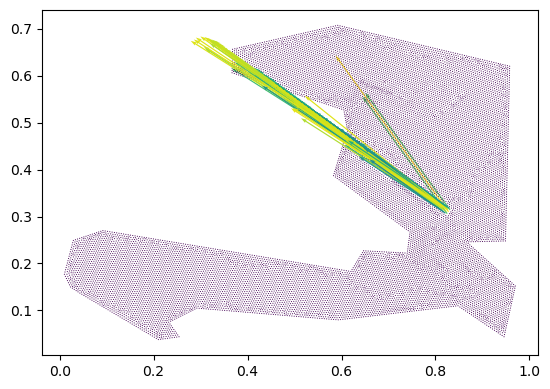

In [115]:
# Get velocity field
P2 = VectorElement('CG',mesh.ufl_cell(),2)
P1 = FiniteElement('CG',mesh.ufl_cell(),1)
W = FunctionSpace(mesh, MixedElement([P2,P1]))
# No-slip boundary condition for velocity 
noslip = Constant((0, 0))
bc0 = DirichletBC(W.sub(0), noslip, sub_bd, 4)

#Assume that the velocity is 1.5m/s
# Inflow boundary condition for velocity
inflow = Expression(("30000/L*((x[1]-1+0.698)*(x[1]-1+0.682)+(x[0]-0.822)*(x[0]-0.834))*157", "-30000/L*((x[1]-1+0.698)*(x[1]-1+0.682)+(x[0]-0.822)*(x[0]-0.834))*217"),L = Length_Unit, degree = 2)
bc1 = DirichletBC(W.sub(0), inflow, sub_bd, 2)

# Boundary condition for pressure at outflow
zero = Constant(0)
bc2 = DirichletBC(W.sub(1), zero, sub_bd, 3)

# Collect boundary conditions
bcs = [bc0, bc1, bc2]
(u, p) = TrialFunctions(W)
(phi, q) = TestFunctions(W)
f = Constant((0, 0))
a = (inner(grad(u), grad(phi)) - div(phi)*p + q*div(u))*dx(6)
L = inner(f, phi)*dx(6)

A = assemble(a, keep_diagonal= True)
A.ident_zeros()
b = assemble(L)
[bc.apply(A, b) for bc in bcs]

# Compute solution
w = Function(W)
solve(A, w.vector(), b, 'lu')

# Split the mixed solution using deepcopy
# (needed for further computation on coefficient vector)
(u, p) = w.split(True)


# # Split the mixed solution using a shallow copy
(u, p) = w.split()

plot (u)

In [116]:
ufile_pvd = File("velocity.pvd")
ufile_pvd << u

In [117]:
# Define normal vector and mesh size
n = FacetNormal(mesh)
h = CellDiameter(mesh)
h_avg = (h('+') + h('-'))/2
un = (dot(u, n) + abs(dot(u, n)))/2.0

interior boundaries: 0  
land boundary: 1  
inflow: 2  
outflow: 3  
interface: 4  
land: 5  
water: 6  

In [118]:
F_B = inner(1/(T_hat*k)*(B-B0)-g_B*(1-(C_hat*B0/K_B))*B+delta*B,v)*dx(5) + dot(D_4/(L_hat*L_hat)*grad(B),grad(v))*dx(5)\
    + inner(1/(T_hat*k)*(B-B0)-g_B*(1-(C_hat*B0/K_B))*B+delta*B,v)*dx(6) - dot(B/(T_hat)*u-D_4/(L_hat*L_hat)*grad(B),grad(v))*dx(6)\
    + c_g/(L_hat*L_hat*h_avg)*dot(jump(D_4*B,n),jump(v,n))*dS(0) \
    + c_g/(L_hat*L_hat*h_avg)*dot(jump(D_4*B,n),jump(v,n))*dS(2) \
    + dot(jump(v), un('+')*B('+') - un('-')*B('-'))/(T_hat)*dS(0)\
    - dot(avg(D_4*grad(B)),jump(v,n))/(L_hat*L_hat)*dS(0) \
    - dot(avg(D_4*grad(B)),jump(v,n))/(L_hat*L_hat)*dS(2) \
    + eta*dot(jump(B,n),jump(v,n))*dS(4) + eta*dot(jump(B,n),jump(v,n))*dS(2) + dot(u,n)/(T_hat)*B*v*ds(3)\
    - xi*N_hat/(C_hat)*I0*v*dx 
 
B1 = Function(V, name='Bacteria')
a_B = lhs(F_B)
L_B = rhs(F_B)
b_B = assemble(L_B)
A_B = assemble(a_B)
solve(A_B, B1.vector(), b_B, 'lu')
# solve(a_B == L_B, p)
B0.assign(B1)
F_S = inner((1/(k*T_hat))*(S-S0),v)*dx(5) - Lamda/(N_hat)*v*dx(5) + beta_H*N_hat*S0*I0*v*dx(5)\
    + beta_E*S*B0/(B0+K/C_hat)*v*dx(5)\
    + d*S*v*dx(6) + dot(D_1*grad(S),grad(v))/(L_hat*L_hat)*dx(5) \
    + c_g/(L_hat*L_hat)*(D_1/h_avg)*dot(jump(S,n),jump(v,n))*dS(0)\
    + dot(avg(D_1*grad(S)),jump(v,n))/(L_hat*L_hat)*dS(0) + S*v*dx(6)
S1 = Function(V, name='Susceptible')
a_S = lhs(F_S)
L_S = rhs(F_S)
b_S = assemble(L_S)
A_S = assemble(a_S)
solve(A_S, S1.vector(), b_S, 'lu')

F_I = inner((1/(k*T_hat))*(I-I0),v)*dx(5)  - beta_H*N_hat*S0*I0*v*dx(5) - beta_E*S1*B0/(B0+K/C_hat)*v*dx(5)\
    + (d+m+gamma)*I*v*dx(5) + dot(D_2*grad(I),grad(v))/(L_hat*L_hat)*dx(5)\
    + c_g/(L_hat*L_hat)*(D_2/h_avg)*dot(jump(I,n),jump(v,n))*dS(0)\
    + dot(avg(D_2*grad(I)),jump(v,n))/(L_hat*L_hat)*dS(0) + I*v*dx(7)
I1 = Function(V, name='Infectious')
a_I = lhs(F_I)
L_I = rhs(F_I)
b_I = assemble(L_I)
A_I = assemble(a_I)
solve(A_I, I1.vector(), b_I, 'lu')



F_R = inner((1/(T_hat*k))*(R-R0),v)*dx(5) + d*R*v*dx(5) \
    - gamma*I1*v*dx(5) + dot(D_3*grad(R),grad(v))/(L_hat*L_hat)*dx(5) \
    + c_g*D_3/(L_hat*L_hat*h_avg)*dot(jump(R,n),jump(v,n))*dS(0)\
    + dot(avg(D_3*grad(R)),jump(v,n))/(L_hat*L_hat)*dS(0) + R*v*dx(6)

R1 = Function(V, name='Recovered')
a_R = lhs(F_R)
L_R = rhs(F_R)
b_R = assemble(L_R)
A_R = assemble(a_R)
solve(A_R, R1.vector(), b_R, 'lu')


S0.assign(S1)
I0.assign(I1)
R0.assign(R1)

Calling FFC just-in-time (JIT) compiler, this may take some time.


In [119]:
p_file = XDMFFile('./results/bacteria.xdmf')

t=dt
p_file.write(B1, t)
# p_file.close()
s_file = XDMFFile('./results/susceptible.xdmf')

s_file.write(S1, t)
# s_file.close()

i_file = XDMFFile('./results/infectious.xdmf')

i_file.write(I1, t)
# i_file.close()

r_file = XDMFFile('./results/recovered.xdmf')

r_file.write(R1, t)
# r_file.close()

In [120]:
while t < T + DOLFIN_EPS:
    #cI.t = t
    t += dt
    info("time stepping t/T = {}/{}".format(t, T))
    # Compute tentative velocity step
    a_B = lhs(F_B)
    L_B = rhs(F_B)
    b_B = assemble(L_B)
    A_B = assemble(a_B)
    solve(A_B, B1.vector(), b_B, 'lu')
    B0.assign(B1)   

    a_S = lhs(F_S)
    L_S = rhs(F_S)
    b_S = assemble(L_S)
    A_S = assemble(a_S)
    solve(A_S, S1.vector(), b_S, 'lu')
    a_I = lhs(F_I)
    L_I = rhs(F_I)
    b_I = assemble(L_I)
    A_I = assemble(a_I)
    solve(A_I, I1.vector(), b_I, 'lu')
    a_R = lhs(F_R)
    L_R = rhs(F_R)
    b_R = assemble(L_R)
    A_R = assemble(a_R)
    solve(A_R, R1.vector(), b_R, 'lu')
    S0.assign(S1)
    I0.assign(I1)
    R0.assign(R1)
    # Save to file
    p_file.write(B1, t)

    s_file.write(S1, t)

    i_file.write(I1, t)
    
    r_file.write(R1, t)
    

    # Move to next time step

time stepping t/T = 0.2/30
time stepping t/T = 0.30000000000000004/30
time stepping t/T = 0.4/30
time stepping t/T = 0.5/30
time stepping t/T = 0.6/30
time stepping t/T = 0.7/30
time stepping t/T = 0.7999999999999999/30
time stepping t/T = 0.8999999999999999/30
time stepping t/T = 0.9999999999999999/30
time stepping t/T = 1.0999999999999999/30
time stepping t/T = 1.2/30
time stepping t/T = 1.3/30
time stepping t/T = 1.4000000000000001/30
time stepping t/T = 1.5000000000000002/30
time stepping t/T = 1.6000000000000003/30
time stepping t/T = 1.7000000000000004/30
time stepping t/T = 1.8000000000000005/30
time stepping t/T = 1.9000000000000006/30
time stepping t/T = 2.0000000000000004/30
time stepping t/T = 2.1000000000000005/30
time stepping t/T = 2.2000000000000006/30
time stepping t/T = 2.3000000000000007/30
time stepping t/T = 2.400000000000001/30
time stepping t/T = 2.500000000000001/30
time stepping t/T = 2.600000000000001/30
time stepping t/T = 2.700000000000001/30
time stepping t/

In [121]:
i_file.close()
r_file.close()
s_file.close()
p_file.close()